In [24]:
import pymupdf
import re
import os, sys
import pathlib
from threading import Thread, Lock
import concurrent.futures
import time
from collections.abc import Iterable
import cv2
from pdf2image import convert_from_path
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# how to read OCR scanned pages
* first convert pdf pages to images
* then use PIL to enhance the images
* convert the images back to pdf
* use pymupdf to read the pages using the ocr function

In [35]:
path = '/home/ngoni97/Documents/Documents/MATHEMATICS/Principia Mathematica/Principia_Mathematica [volume.I] alfred_north_whitehead x betrand_russell.pdf'
folder = '/home/ngoni97/Documents/Documents/File Manager with ML/train_test_text_files/images_test/Original Images'
#pages = convert_from_path(path, last_page=10, dpi=300, output_folder=folder, fmt='png')
pages = convert_from_path(path, last_page=10, dpi=300, fmt='png')

In [36]:
pages

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=2542x2894>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1962x2861>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1874x2802>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1884x2813>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1845x2781>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1845x2781>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1844x2784>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1844x2780>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1842x2779>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1843x2775>]

In [37]:
from PIL import Image

for i, img in enumerate(pages, 1):
    print(f"\nPage {i} Info:")
    print(f"  Size: {img.size}")
    print(f"  Mode: {img.mode}")
    print(f"  Format: {img.format}")
        
    # Example PIL operations
    # Convert to grayscale
    gray_img = img.convert('L')
        
    # Resize image
    resized = img.resize((800, 600))
        
    # Crop image (left, top, right, bottom)
    width, height = img.size
    cropped = img.crop((0, 0, width//2, height//2))
        
    # Get pixel data
    pixel_data = list(img.getdata())
    print(f"  Total pixels: {len(pixel_data)}")



Page 1 Info:
  Size: (2542, 2894)
  Mode: RGB
  Format: PNG
  Total pixels: 7356548

Page 2 Info:
  Size: (1962, 2861)
  Mode: RGB
  Format: PNG
  Total pixels: 5613282

Page 3 Info:
  Size: (1874, 2802)
  Mode: RGB
  Format: PNG
  Total pixels: 5250948

Page 4 Info:
  Size: (1884, 2813)
  Mode: RGB
  Format: PNG
  Total pixels: 5299692

Page 5 Info:
  Size: (1845, 2781)
  Mode: RGB
  Format: PNG
  Total pixels: 5130945

Page 6 Info:
  Size: (1845, 2781)
  Mode: RGB
  Format: PNG
  Total pixels: 5130945

Page 7 Info:
  Size: (1844, 2784)
  Mode: RGB
  Format: PNG
  Total pixels: 5133696

Page 8 Info:
  Size: (1844, 2780)
  Mode: RGB
  Format: PNG
  Total pixels: 5126320

Page 9 Info:
  Size: (1842, 2779)
  Mode: RGB
  Format: PNG
  Total pixels: 5118918

Page 10 Info:
  Size: (1843, 2775)
  Mode: RGB
  Format: PNG
  Total pixels: 5114325


page_1
page_2
page_3
page_4
page_5
page_6
page_7
page_8
page_9
page_10


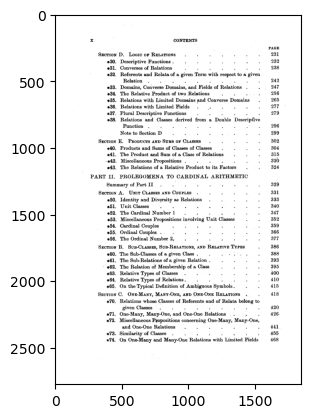

In [31]:
for pg_num, image in enumerate(pages, 1):
    print(f"page_{pg_num}")
    plt.imshow(image)

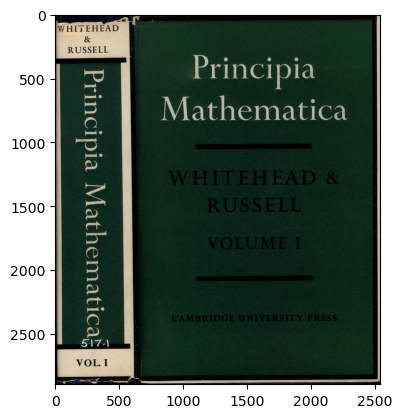

In [38]:
plt.imshow(pages[0])

In [34]:
for i in range(len(pages)):
    pages[i].show()

In [41]:
def advanced_image_preprocessing(image):
    """
    Advanced image preprocessing for better OCR results
    """
    # Convert to grayscale if needed
    if image.mode != 'L':
        image = image.convert('L')
    
    # Convert to numpy array
    img_array = np.array(image)
    
    # 1. Noise reduction
    img_array = cv2.medianBlur(img_array, 3)
    
    # 2. Gaussian blur to smooth
    img_array = cv2.GaussianBlur(img_array, (1, 1), 0)
    
    # 3. Adaptive thresholding for better text separation
    img_array = cv2.adaptiveThreshold(
        img_array, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # 4. Morphological operations to clean up
    kernel = np.ones((1, 1), np.uint8)
    img_array = cv2.morphologyEx(img_array, cv2.MORPH_CLOSE, kernel)
    img_array = cv2.morphologyEx(img_array, cv2.MORPH_OPEN, kernel)
    
    # Convert back to PIL Image
    processed_image = Image.fromarray(img_array)
    
    # 5. PIL-specific enhancements
    # Enhance contrast
    enhancer = ImageEnhance.Contrast(processed_image)
    processed_image = enhancer.enhance(1.2)
    
    # Enhance sharpness
    enhancer = ImageEnhance.Sharpness(processed_image)
    processed_image = enhancer.enhance(1.5)
    
    return processed_image

In [57]:
def convert_pdf_to_images(file_path, save_images=False, prefix='page', fmt='PNG'):
    destn = '/home/ngoni97/Documents/Documents/File Manager with ML/train_test_text_files/images_test'
    if save_images:
        if not os.path.exists(destn):
            os.makedirs(destn, exist_ok=True)
        original_images = os.path.join(destn, 'Original Images')
        if not os.path.exists(original_images):
            os.makedirs(original_images, exist_ok=True)
        enhanced_images = os.path.join(destn, 'Enhanced Images')
        if not os.path.exists(enhanced_images):
            os.makedirs(enhanced_images)
        
        images = convert_from_path(file_path, last_page=10, dpi=300, output_folder=original_images, fmt='png')

        for i, img in enumerate(images,1):
            filename = f"{prefix}_{i:03d}.{fmt.lower()}"
            filepath = os.path.join(original_images, filename)
            img.save(filepath, fmt)
            print(f"Saved: {filepath}")
    else:
        images = convert_from_path(file_path, last_page=10, dpi=300, fmt=fmt)
        for img in images:
            img.show()

    # saving enhanced versions
    Images = []
    for image in images:
        enhanced_image = advanced_image_preprocessing(image)
        Images.append(enhanced_image)

    for i, enhanced_image in enumerate(Images, 1):
        file_name = f"{prefix}_{i:03d}.{fmt.lower()}"
        file_path = os.path.join(enhanced_images, file_name)
        enhanced_image.save(file_path, fmt)
        print(f"Saved as pdf: {file_path}")
    

In [58]:
test_path = '/home/ngoni97/Documents/Documents/MATHEMATICS/Principia Mathematica/Principia_Mathematica [volume.I] alfred_north_whitehead x betrand_russell.pdf'
convert_pdf_to_images(test_path, fmt='PDF')

UnboundLocalError: cannot access local variable 'enhanced_images' where it is not associated with a value

In [ ]:
import os
from pdf2image import convert_from_path, convert_from_bytes
from PIL import Image
import io

def convert_pdf_to_images(pdf_path, output_dir=None, dpi=200, fmt='PNG'):
    """
    Convert PDF to images using pdf2image
    
    Args:
        pdf_path (str): Path to the PDF file
        output_dir (str): Directory to save images (optional)
        dpi (int): DPI for image conversion (default: 200)
        fmt (str): Output format ('PNG', 'JPEG', etc.)
    
    Returns:
        list: List of PIL Image objects
    """
    try:
        # Convert PDF to list of PIL Images
        images = convert_from_path(
            pdf_path,
            dpi=dpi,
            output_folder=output_dir,
            fmt=fmt
        )
        
        print(f"Successfully converted {len(images)} pages from {pdf_path}")
        return images
        
    except Exception as e:
        print(f"Error converting PDF: {e}")
        return []

def convert_pdf_from_bytes(pdf_bytes, dpi=200):
    """
    Convert PDF from bytes to images
    
    Args:
        pdf_bytes (bytes): PDF file as bytes
        dpi (int): DPI for conversion
    
    Returns:
        list: List of PIL Image objects
    """
    try:
        images = convert_from_bytes(pdf_bytes, dpi=dpi)
        print(f"Successfully converted {len(images)} pages from bytes")
        return images
    except Exception as e:
        print(f"Error converting PDF from bytes: {e}")
        return []

def save_images_to_disk(images, output_dir, prefix="page", fmt="PNG"):
    """
    Save PIL images to disk
    
    Args:
        images (list): List of PIL Image objects
        output_dir (str): Output directory
        prefix (str): Filename prefix
        fmt (str): Image format
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for i, img in enumerate(images):
        filename = f"{prefix}_{i+1:03d}.{fmt.lower()}"
        filepath = os.path.join(output_dir, filename)
        img.save(filepath, fmt)
        print(f"Saved: {filepath}")

def process_images_with_pil(images):
    """
    Process images using PIL operations
    
    Args:
        images (list): List of PIL Image objects
    """
    for i, img in enumerate(images):
        print(f"\nPage {i+1} Info:")
        print(f"  Size: {img.size}")
        print(f"  Mode: {img.mode}")
        print(f"  Format: {img.format}")
        
        # Example PIL operations
        # Convert to grayscale
        gray_img = img.convert('L')
        
        # Resize image
        resized = img.resize((800, 600))
        
        # Crop image (left, top, right, bottom)
        width, height = img.size
        cropped = img.crop((0, 0, width//2, height//2))
        
        # Get pixel data
        pixel_data = list(img.getdata())
        print(f"  Total pixels: {len(pixel_data)}")

def convert_with_specific_pages(pdf_path, first_page=1, last_page=None):
    """
    Convert specific pages from PDF
    
    Args:
        pdf_path (str): Path to PDF
        first_page (int): First page to convert (1-indexed)
        last_page (int): Last page to convert (optional)
    
    Returns:
        list: PIL Image objects for specified pages
    """
    try:
        images = convert_from_path(
            pdf_path,
            first_page=first_page,
            last_page=last_page,
            dpi=200
        )
        print(f"Converted pages {first_page} to {last_page or 'end'}")
        return images
    except Exception as e:
        print(f"Error converting specific pages: {e}")
        return []

def image_to_bytes(image, fmt='PNG'):
    """
    Convert PIL Image to bytes
    
    Args:
        image: PIL Image object
        fmt (str): Output format
    
    Returns:
        bytes: Image as bytes
    """
    img_bytes = io.BytesIO()
    image.save(img_bytes, format=fmt)
    return img_bytes.getvalue()

def main():
    # Example usage
    pdf_file = "example.pdf"
    output_directory = "output_images"
    
    # Convert entire PDF
    print("Converting entire PDF...")
    images = convert_pdf_to_images(pdf_file, dpi=150)
    
    if images:
        # Process images with PIL
        process_images_with_pil(images)
        
        # Save to disk
        save_images_to_disk(images, output_directory)
        
        # Example: Convert first image to different formats
        first_image = images[0]
        
        # Save as JPEG
        jpeg_path = os.path.join(output_directory, "first_page.jpg")
        first_image.save(jpeg_path, "JPEG", quality=95)
        
        # Save as PNG
        png_path = os.path.join(output_directory, "first_page.png")
        first_image.save(png_path, "PNG")
        
        # Convert to bytes
        img_bytes = image_to_bytes(first_image)
        print(f"Image as bytes: {len(img_bytes)} bytes")
    
    # Convert specific pages
    print("\nConverting specific pages...")
    specific_pages = convert_with_specific_pages(pdf_file, first_page=1, last_page=3)
    
    # Example: Load PDF from bytes
    if os.path.exists(pdf_file):
        with open(pdf_file, 'rb') as f:
            pdf_bytes = f.read()
        
        print("\nConverting from bytes...")
        images_from_bytes = convert_pdf_from_bytes(pdf_bytes)

# Advanced example with error handling and optimization
def batch_convert_pdfs(pdf_directory, output_base_dir):
    """
    Convert multiple PDFs in batch
    
    Args:
        pdf_directory (str): Directory containing PDF files
        output_base_dir (str): Base output directory
    """
    for filename in os.listdir(pdf_directory):
        if filename.lower().endswith('.pdf'):
            pdf_path = os.path.join(pdf_directory, filename)
            pdf_name = os.path.splitext(filename)[0]
            output_dir = os.path.join(output_base_dir, pdf_name)
            
            print(f"\nProcessing: {filename}")
            images = convert_pdf_to_images(pdf_path, dpi=150)
            
            if images:
                save_images_to_disk(images, output_dir, prefix=pdf_name)

if __name__ == "__main__":
    main()
